# Final Model Report, comparing Random Forest with the Baseline Model


### Introduction:

The notebook aims to evaluate the performance of a Random Forest model in comparison to a Baseline model. The goal is to determine how accurate and reliable the model predictions are when applied to the test set.

### Implemented Steps and Techniques Used

Baseline Model Evaluation:

The performance metrics of a baseline model are presented as follows:

AUC: 0.5032

Precision: 0.1553

Recall: 0.0399

Accuracy: 0.8427

F1 Score: 0.0635


### Data Preprocessing:

Data extraction is performed to gather a 10000 case IDs for processing.

Techniques such as SimpleImputer, IterativeImputer, and SMOTE are used for handling missing values and dealing with class imbalance.


### Model Implementation:

#### Random Forest Classifier:

- Hyperparameter tuning is conducted using GridSearchCV and RandomizedSearchCV.

##### Feature Selection:
- Top 30 features are selected for model training.


#### Scaling:

- Data scaling is performed using StandardScaler.


#### Pipeline and Cross-validation:

- An imbalanced-learn pipeline (ImbPipeline) is set up to integrate preprocessing steps and the classifier.
- Cross-validation strategies include StratifiedKFold and cross_val_score.


#### Dimensionality Reduction:

- Linear Discriminant Analysis (LDA) is applied to reduce the dimensionality of the dataset.

# Random Forest on Top 30 features

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Data Cleaning and Preprocessing

#### Extract 10000 case_id's for num_group = 0 from the preprocessed dataset.

In [2]:
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [3]:
df = merge_n_case_ids(
    n_ids=10000,
    data_dir='/kaggle/input/cr-newagg/new_aggs',
    path_to_base='/kaggle/input/datasets-cr/train_base.parquet',
    use_0=True,
    as_pandas=True,
    random_state=28  
)

In [4]:
# Extract date info from base
df['date_decision'] = pd.to_datetime(df['date_decision'])
df['dec_day'] = df['date_decision'].dt.day
df['dec_month'] = df['date_decision'].dt.month
df['dec_year'] = df['date_decision'].dt.year

# Drop redundant information
df = df.drop(columns=[
    'date_decision'
])

In [5]:
df.head()

,case_id,MONTH,WEEK_NUM,target,amount_4527230A_min,amount_4527230A_max,amount_4527230A_mean,amount_4527230A_median,amount_4527230A_sum,recorddate_4527225D_min,...,openingdate_857D_distinct,openingdate_857D_min_year,openingdate_857D_min_month,openingdate_857D_min_day,openingdate_857D_max_year,openingdate_857D_max_month,openingdate_857D_max_day,dec_day,dec_month,dec_year
0,4,201901,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
1,134,201901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
2,199,201901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
3,496,201901,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1,2019
4,672,201901,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2019


Drop the redundant object columns from the dataset as they already exist as preprocessed numerical columns.

In [6]:
object_cols = ['recorddate_4527225D_min', 'recorddate_4527225D_max', 'dateofcredend_289D_min', 'dateofcredend_353D_min', 'dateofcredstart_181D_min', 'dateofcredstart_739D_min', 
               'dateofrealrepmt_138D_min', 'lastupdate_1112D_min', 
               'lastupdate_388D_min', 'numberofoverdueinstlmaxdat_148D_min', 'numberofoverdueinstlmaxdat_641D_min', 'overdueamountmax2date_1002D_min', 'overdueamountmax2date_1142D_min', 'refreshdate_3813885D_min', 
               'dateofcredend_289D_max', 'dateofcredend_353D_max', 'dateofcredstart_181D_max', 'dateofcredstart_739D_max', 'dateofrealrepmt_138D_max', 'lastupdate_1112D_max', 'lastupdate_388D_max', 
               'numberofoverdueinstlmaxdat_148D_max', 'numberofoverdueinstlmaxdat_641D_max', 'overdueamountmax2date_1002D_max', 'overdueamountmax2date_1142D_max', 'refreshdate_3813885D_max', 
               'contractenddate_991D_min', 'openingdate_313D_min', 
               'contractenddate_991D_max', 'openingdate_313D_max', 'pmts_date_1107D_min', 'pmts_date_1107D_max', 'approvaldate_319D_min', 'creationdate_885D_min', 
               'dateactivated_425D_min', 'dtlastpmt_581D_min', 'dtlastpmtallstes_3545839D_min', 'employedfrom_700D_min', 'firstnonzeroinstldate_307D_min', 'approvaldate_319D_max', 
               'creationdate_885D_max', 'dateactivated_425D_max', 'dtlastpmt_581D_max', 'dtlastpmtallstes_3545839D_max', 'employedfrom_700D_max', 'firstnonzeroinstldate_307D_max', 
               'empls_employedfrom_796D_min', 'empls_employedfrom_796D_max', 'processingdate_168D_min', 'processingdate_168D_max', 'contractdate_551D_min', 'contractmaturitydate_151D_min', 
               'lastupdate_260D_min', 'contractdate_551D_max', 'contractmaturitydate_151D_max', 'lastupdate_260D_max', 'birth_259D_min', 'birthdate_87D_min', 'empl_employedfrom_271D_min', 
               'birth_259D_max', 'birthdate_87D_max', 'empl_employedfrom_271D_max', 'deductiondate_4917603D_min', 'deductiondate_4917603D_max', 'openingdate_857D_min', 'openingdate_857D_max']

# Drop the object columns from the DataFrame
df.drop(columns=object_cols, inplace=True)

# Print the new DataFrame information to confirm columns are deleted
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1360 entries, case_id to dec_year
dtypes: float64(1230), int32(5), int64(4), int8(99), object(14), uint32(8)
memory usage: 96.7+ MB
None


Impute the missing values with mean.

In [7]:
df.fillna(df.mean(), inplace=True)

# Model Building: Random Forest on top 30 features

In [8]:
# Count the occurrences of each unique value in 'target'
value_counts = df['target'].value_counts().reset_index()
value_counts.columns = ['target', 'count']

# Calculate the total number of rows in the DataFrame
total_count = df.shape[0]  # This returns the number of rows

# Calculate the proportion of each 'target' value
value_counts['proportion'] = value_counts['count'] / total_count

# Print the result
print(value_counts)

   target  count  proportion
0       0   9667      0.9667
1       1    333      0.0333


The ratio of fraud to non-fraud observations is very low. Need to use techniques such as oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes before model training.

In [9]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

____________________________________________________________________________________________________

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


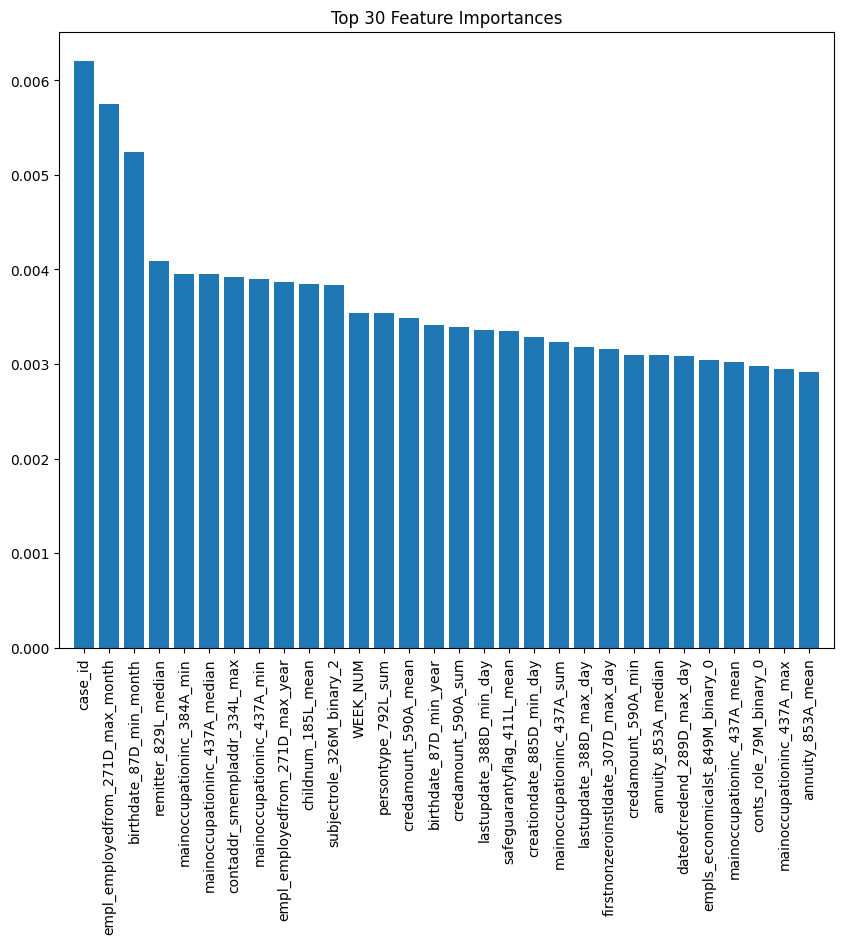

In [11]:
# Create an imputer object that fills in missing values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Create a pipeline that first imputes the missing values, then fits a RandomForestClassifier
pipeline = Pipeline([
    ('imputer', imputer),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model on the training data
pipeline.fit(X, y)

# Extract the feature importances from the classifier
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting only the top 30 features for readability
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances")
plt.bar(range(30), importances[indices[:30]], align='center')
plt.xticks(range(30), X.columns[indices[:30]], rotation=90)
plt.xlim([-1, 30])
plt.show()

In [12]:
top_30_indices = indices[:30]
top_30_features = X.columns[top_30_indices]

# Create a new DataFrame with only the top 30 features
X_top_30 = X[top_30_features]


In [13]:
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]


Accuracy: 0.83
Precision: 0.06
Recall: 0.25
AUC: 0.58
F1 Score: 0.10


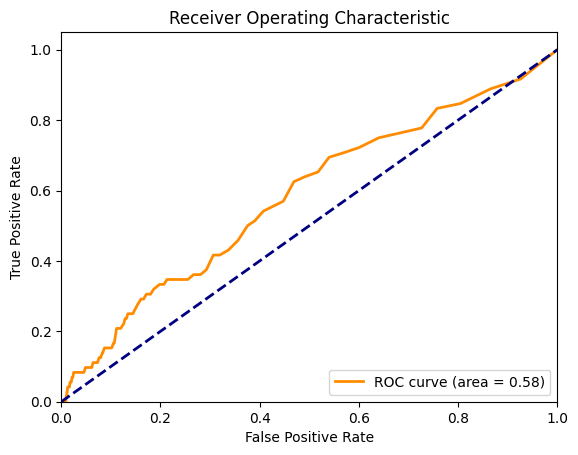

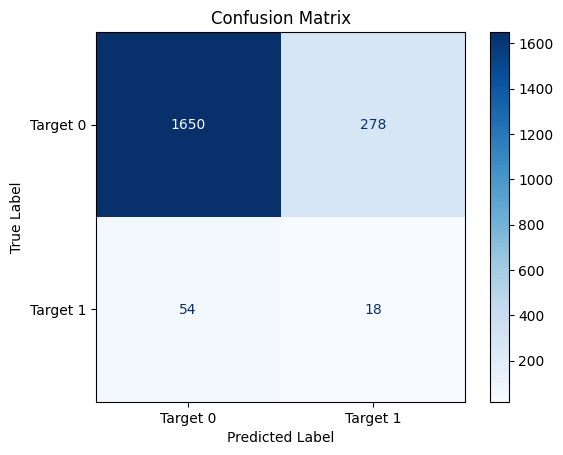

In [16]:
# Define the pipeline using imblearn's Pipeline
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),  # Imputing missing values
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None, class_weight={0: 1, 1: 10}, random_state=42))
])

pipeline.fit(X_train_top30, y_train)
y_proba = pipeline.predict_proba(X_test_top30)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate metrics
threshold = 0.2 
y_pred_adjusted = (y_proba > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_proba)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'AUC: {auc_score:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for adjusted threshold predictions
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Target 0', 'Target 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Comparison of Random Forest Model Results with Baseline Model Performance Metrics

AUC (Area Under the Curve):

- Baseline Model: 50.32%
- Random Forest: 58%
- Analysis: The Random Forest model has a higher AUC, indicating better performance in distinguishing between positive and negative classes.

Precision:

- Baseline Model: 15.53%
- Random Forest: 6%
- Analysis: The baseline model has a higher precision, meaning it is more accurate in predicting positive instances compared to the Random Forest model.

Recall:

- Baseline Model: 3.99%
- Random Forest: 25%
- Analysis: The Random Forest model has a significantly higher recall, indicating it is better at identifying all positive instances.

Accuracy:

- Baseline Model: 84.27%
- Random Forest: 83%
- Analysis: The baseline model has a slightly higher accuracy compared to the Random Forest model.

F1 Score:

- Baseline Model: 6.35%
- Random Forest: 10%
- Analysis: The Random Forest model has a higher F1 score, suggesting a better balance between precision and recall.

### Conclusion:

The Random Forest model with the top 30 features demonstrates improved performance in terms of AUC, recall, and F1 score when compared to the baseline model. While the baseline model shows higher precision and slightly better accuracy, the Random Forest model's ability to identify positive instances (recall) and its overall balance between precision and recall (F1 score) are significantly better. This suggests that the Random Forest model may be more effective for applications where identifying positive cases is critical, even if it means sacrificing some precision.

_______________________________________________________________________________________________________

## Standardization


In [47]:
# Standardize the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## LDA


In [48]:
# Apply LDA for dimensionality reduction
lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)


## SMOTE

In [49]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_lda, y_train)


Performed Standardization, LDA and SMOTE to ensure the data is standardized, reduced in dimensionality while preserving class information, and balanced for improved model training and performance.

## Hyperparameter Tuning with RandomForest

In [ ]:
# Define hyperparameters grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
model_rf = RandomForestClassifier(random_state=1)

# Configure RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_iter=50, 
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2,
    random_state=1
)

# Fit the model on the resampled training data
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model_rf = random_search_rf.best_estimator_


In [53]:
best_model_rf

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400, random_state=1)

In [54]:
# Predict using the best model on the test set
y_test_pred = best_model_rf.predict(X_test_lda)
y_test_pred_probs = best_model_rf.predict_proba(X_test_lda)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Accuracy: 0.775
ROC AUC: 0.5903498155832181
Confusion Matrix:
 [[1526  402]
 [  48   24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      1928
           1       0.06      0.33      0.10        72

    accuracy                           0.78      2000
   macro avg       0.51      0.56      0.48      2000
weighted avg       0.94      0.78      0.84      2000



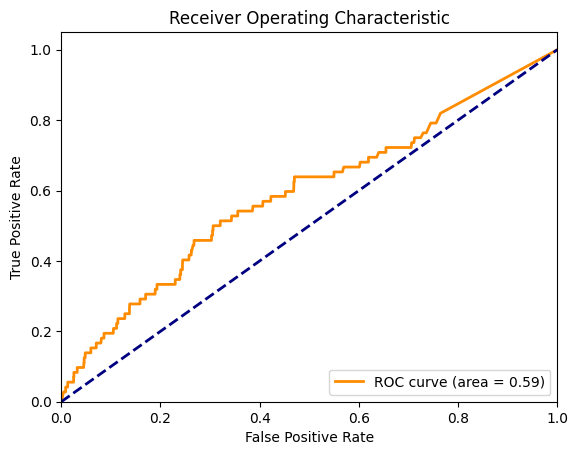

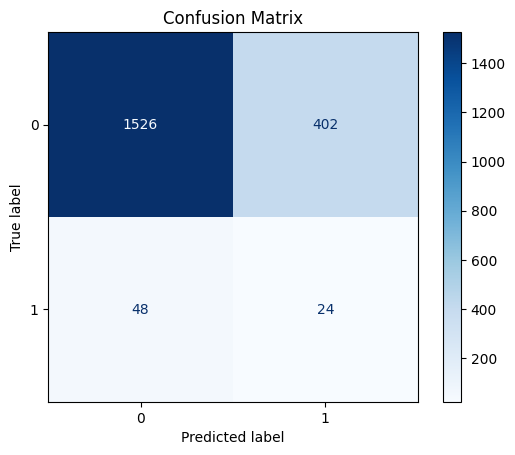

In [57]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

### Comparison of Random Forest Model Results with Baseline Model Performance Metrics

#### Analysis:

AUC (Area Under the Curve):

- Baseline Model: 50.32%
- Random Forest: 59.0%
- Analysis: The Random Forest model significantly improves the AUC compared to the baseline model, indicating better overall performance in distinguishing between positive and negative classes.

Precision:

- Baseline Model: 15.53%
- Random Forest: 6%
- Analysis: The baseline model has a higher precision, meaning it is more accurate in predicting positive instances. The Random Forest model's precision is lower, indicating a higher number of false positives.

Recall:

- Baseline Model: 3.99%
- Random Forest: 33%
- Analysis: The Random Forest model has a much higher recall, indicating it is significantly better at identifying positive instances compared to the baseline model. This is beneficial in scenarios where capturing all positive instances is crucial.

Accuracy:

- Baseline Model: 84.27%
- Random Forest: 77.5%
- Analysis: The baseline model has a higher accuracy, which could be due to a higher number of correctly predicted negative instances. The Random Forest model's lower accuracy reflects its focus on improving recall.

F1 Score:

- Baseline Model: 6.35%
- Random Forest: 10%
- Analysis: The Random Forest model has a higher F1 score, suggesting a better balance between precision and recall compared to the baseline model. This indicates an overall improved performance for the Random Forest model in identifying and predicting positive instances.


### Conclusion:
The Random Forest model with hyperparameter tuning shows a notable improvement in AUC, recall, and F1 score compared to the baseline model. While it sacrifices some precision and accuracy, the improvements in recall and F1 score indicate that it is more effective in identifying positive instances. This makes the Random Forest model more suitable for applications where capturing all positive cases is critical, even if it results in more false positives. The increased AUC further supports its enhanced capability to distinguish between classes, making it a more reliable model overall.